# 06 - Transfer Learning and Fine-tuning

Transfer learning leverages knowledge from models pre-trained on large datasets to solve new tasks with less data and training time. Instead of training a CNN from scratch, we reuse learned features from models trained on millions of images, then adapt them to our specific problem. This approach often achieves better results with significantly less computational cost.

We will use pre-trained models from Keras Applications to classify flower images, demonstrating both feature extraction and fine-tuning strategies.

## Table of Contents

1. [Setup and Data Preparation](#Setup-and-Data-Preparation)
2. [What is Transfer Learning?](#What-is-Transfer-Learning?)
3. [Pre-trained Models in Keras](#Pre-trained-Models-in-Keras)
4. [Feature Extraction with Frozen Backbone](#Feature-Extraction-with-Frozen-Backbone)
5. [Combining Custom CNN with Pre-trained Features](#Combining-Custom-CNN-with-Pre-trained-Features)
6. [Fine-tuning](#Fine-tuning)
7. [Comparing Approaches](#Comparing-Approaches)
8. [Recap](#Recap)

## Setup and Data Preparation

First, let's set up our environment and load the same flowers dataset we used previously.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

%matplotlib inline

### Loading the Flowers Dataset

In [2]:
# Download dataset (~218MB)
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# Handle potential nested directory structure
contents = os.listdir(data_dir)
if 'flower_photos' in contents and len(contents) == 1:
    data_dir = os.path.join(data_dir, 'flower_photos')
    data_dir = pathlib.Path(data_dir)

print(f'Total images: {len(list(data_dir.glob("*/*.jpg")))}')

Total images: 3670


### Creating Datasets

We use the same 96×96 image size and 80/20 train/validation split.

In [3]:
image_size = (96, 96)
batch_size = 64

# Create training dataset (80% of data)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Create validation dataset (20% of data)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f'Classes: {class_names}')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2025-11-16 00:14:12.397695: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-11-16 00:14:12.397724: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-11-16 00:14:12.397733: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-11-16 00:14:12.397762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-16 00:14:12.397776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Dataset Performance Optimization

Configure datasets for efficient training with caching and prefetching.

In [4]:
# Optimize dataset performance - prevents GPU from waiting for data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print('Dataset optimization applied')

Dataset optimization applied


## What is Transfer Learning?

Transfer learning is the practice of using knowledge learned from one task to improve performance on a related task.

### The Core Idea

Instead of training a CNN from scratch:

1. **Start with a pre-trained model**: Trained on a large dataset (e.g., ImageNet with 1.4M images)
2. **Reuse learned features**: Early layers detect edges, textures, shapes—useful for many vision tasks
3. **Adapt to new task**: Replace or retrain only the final classification layers

### Key Benefits

- **Less training data needed**: Pre-trained features work well even with small datasets
- **Faster training**: Only train a small portion of the network
- **Better performance**: Often achieves higher accuracy than training from scratch
- **Lower computational cost**: No need for weeks of training on expensive GPUs

### When Does Transfer Learning Work?

Transfer learning is most effective when:

- **Similar domains**: Source and target tasks both involve images
- **Related features**: Low-level features (edges, textures) transfer well
- **Limited target data**: Small datasets benefit most from pre-trained knowledge

### Two Main Strategies

1. **Feature extraction**: Freeze the pre-trained backbone, train only new layers
2. **Fine-tuning**: Unfreeze some layers and train with a small learning rate

## Pre-trained Models in Keras

Keras provides access to state-of-the-art CNN architectures pre-trained on ImageNet through `tf.keras.applications`.

### Available Models

Some popular options include:

| Model          | Parameters | Speed  | Accuracy | Best For                |
|----------------|-----------|--------|----------|------------------------|
| MobileNetV2    | 3.5M      | Fast   | Good     | Mobile/embedded devices |
| EfficientNetB0 | 5.3M      | Fast   | Better   | Balanced accuracy/speed |
| ResNet50       | 25.6M     | Medium | High     | When accuracy matters   |
| VGG16          | 138M      | Slow   | Good     | Simple architecture     |
| InceptionV3    | 23.9M     | Medium | High     | Multi-scale features    |

### MobileNetV2

We'll use **MobileNetV2** as our backbone:

- Designed for mobile and embedded devices
- Excellent balance of accuracy and speed
- Relatively few parameters (faster to fine-tune)
- Pre-trained on ImageNet (1000 classes of everyday objects)

### ImageNet Pre-training

ImageNet is a large visual database with:

- 1.4 million training images
- 1000 classes (animals, plants, vehicles, objects)
- Many natural images and outdoor scenes

The learned features from ImageNet transfer well to many vision tasks, including flower classification.

## Feature Extraction with Frozen Backbone

The first transfer learning strategy is **feature extraction**: use the pre-trained model as a fixed feature extractor.

### Loading the Pre-trained Model

We load MobileNetV2 with ImageNet weights, excluding the top classification layer.

In [5]:
# Load MobileNetV2 without the classification head (include_top=False removes final Dense layer)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,  # Exclude final classification layer
    weights='imagenet'  # Use ImageNet pre-trained weights
)

print(f'Base model layers: {len(base_model.layers)}')
print(f'Base model output shape: {base_model.output_shape}')

Base model layers: 154
Base model output shape: (None, 3, 3, 1280)


### Freezing the Backbone

We freeze the base model to prevent its weights from being updated during training. This preserves the learned ImageNet features.

In [6]:
# Freeze the base model - prevents weights from updating during training
base_model.trainable = False

print(f'Trainable weights before freezing: {len(base_model.trainable_weights)}')
print(f'Non-trainable weights after freezing: {len(base_model.non_trainable_weights)}')

Trainable weights before freezing: 0
Non-trainable weights after freezing: 260


### Understanding Model-Specific Preprocessing

**Critical:** Each pre-trained model expects inputs preprocessed in a specific way. Using incorrect preprocessing will result in poor performance because the model was trained with specific input ranges and transformations.

Different models use different preprocessing strategies:

- **MobileNetV2**: Scales pixel values from [0, 255] to [-1, 1] range
- **ResNet/VGG**: Subtracts ImageNet mean [103.939, 116.779, 123.68] from RGB channels
- **EfficientNet**: Scales to [0, 1] then normalizes with ImageNet statistics
- **InceptionV3**: Scales to [-1, 1] range

**Always use the model's preprocessing function** (`tf.keras.applications.{model_name}.preprocess_input`) to ensure correct input format.

In [7]:
# Get MobileNetV2-specific preprocessing function
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# This function scales pixel values to [-1, 1] range (MobileNetV2's expected input)

### Building the Transfer Learning Model

We build a new model that:

1. Takes images as input
2. Preprocesses them for MobileNetV2
3. Passes through the frozen backbone (feature extraction)
4. Pools features to a single vector per channel
5. Classifies using new dense layers

In [8]:
# Build the transfer learning model using Functional API
inputs = keras.Input(shape=image_size + (3,))

# Preprocessing: scale to [-1, 1] range expected by MobileNetV2
x = preprocess_input(inputs)

# Pre-trained backbone (frozen): extract high-level features
# training=False keeps batch normalization layers in inference mode
x = base_model(x, training=False)

# Classifier head: convert features to class predictions
x = layers.GlobalAveragePooling2D()(x)  # More efficient than Flatten, reduces parameters
x = layers.Dropout(0.5)(x)  # Regularization to prevent overfitting
outputs = layers.Dense(num_classes, activation='softmax')(x)  # Final classification

model_transfer = keras.Model(inputs, outputs, name='transfer_learning_model')

### Model Summary

In [9]:
model_transfer.summary()

# Count trainable vs non-trainable parameters
trainable_count = sum([tf.size(w).numpy() for w in model_transfer.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in model_transfer.non_trainable_weights])

print(f'\nTrainable parameters: {trainable_count:,}')
print(f'Non-trainable parameters: {non_trainable_count:,}')
print(f'Total parameters: {trainable_count + non_trainable_count:,}')

Model: "transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                   

**Observations:**

- Most parameters are frozen (non-trainable) - preserves ImageNet knowledge
- Only the new classification layers are trainable - adapts to flower classes
- Training will be fast since we update very few parameters

### Training the Model

We compile and train with the frozen backbone.

In [10]:
model_transfer.compile(
    optimizer='adam',  # Default learning rate (1e-3) is fine for new layers
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

epochs_initial = 10
history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_initial
)

Epoch 1/10


2025-11-16 00:14:14.745691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 7s 73ms/step - loss: 1.3839 - accuracy: 0.5140 - val_loss: 0.6422 - val_accuracy: 0.7670
Epoch 2/10
46/46 [==============================] - 2s 47ms/step - loss: 0.6254 - accuracy: 0.7786 - val_loss: 0.5270 - val_accuracy: 0.8065
Epoch 3/10
46/46 [==============================] - 2s 47ms/step - loss: 0.4464 - accuracy: 0.8457 - val_loss: 0.4884 - val_accuracy: 0.8215
Epoch 4/10
46/46 [==============================] - 2s 47ms/step - loss: 0.3437 - accuracy: 0.8835 - val_loss: 0.4666 - val_accuracy: 0.8283
Epoch 5/10
46/46 [==============================] - 2s 47ms/step - loss: 0.2728 - accuracy: 0.9142 - val_loss: 0.4574 - val_accuracy: 0.8324
Epoch 6/10
46/46 [==============================] - 2s 33ms/step - loss: 0.2248 - accuracy: 0.9353 - val_loss: 0.4544 - val_accuracy: 0.8406
Epoch 7/10
46/46 [==============================] - 1s 31ms/step - loss: 0.1856 - accuracy: 0.9544 - val_loss: 0.4437 - val_accuracy: 0.8392
Epoch 8/10
46/46 [======

### Visualizing Results

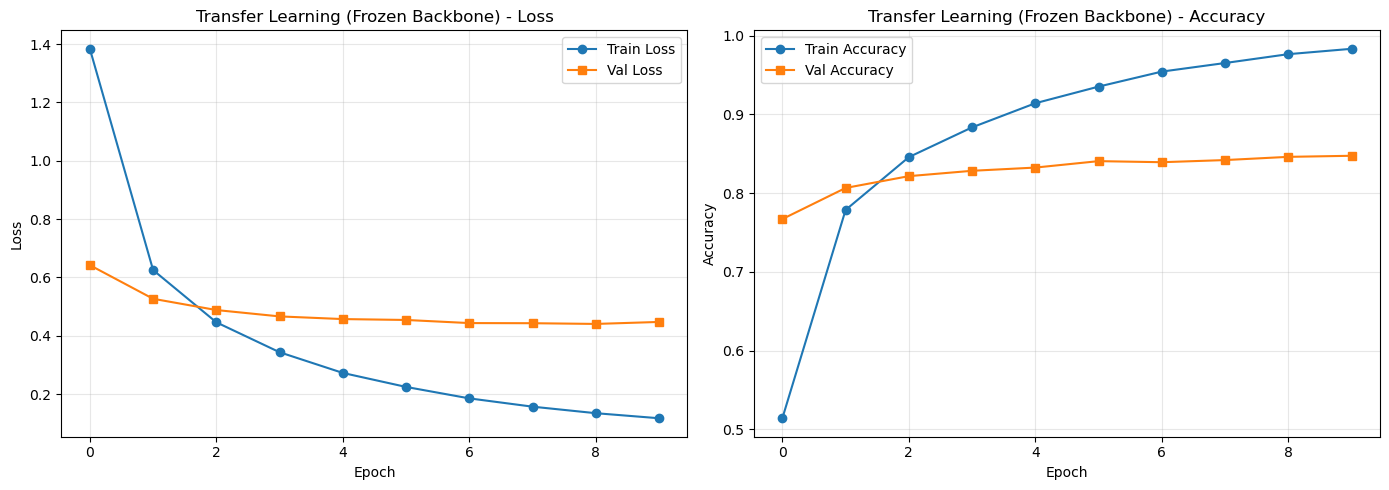

In [11]:
import pandas as pd

def plot_training_history(history, title='Training History'):
    """Plot training and validation metrics."""
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    ax1.plot(hist['epoch'], hist['loss'], label='Train Loss', marker='o')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy', marker='o')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_transfer, 'Transfer Learning (Frozen Backbone)')

### Evaluating Performance

In [12]:
val_loss_transfer, val_acc_transfer = model_transfer.evaluate(val_ds, verbose=0)
print(f'Transfer Learning Results (Frozen Backbone):')
print(f'  Validation Loss: {val_loss_transfer:.4f}')
print(f'  Validation Accuracy: {val_acc_transfer:.4f}')

Transfer Learning Results (Frozen Backbone):
  Validation Loss: 0.4476
  Validation Accuracy: 0.8474


### Making Predictions

Let's visualize some predictions on validation images.

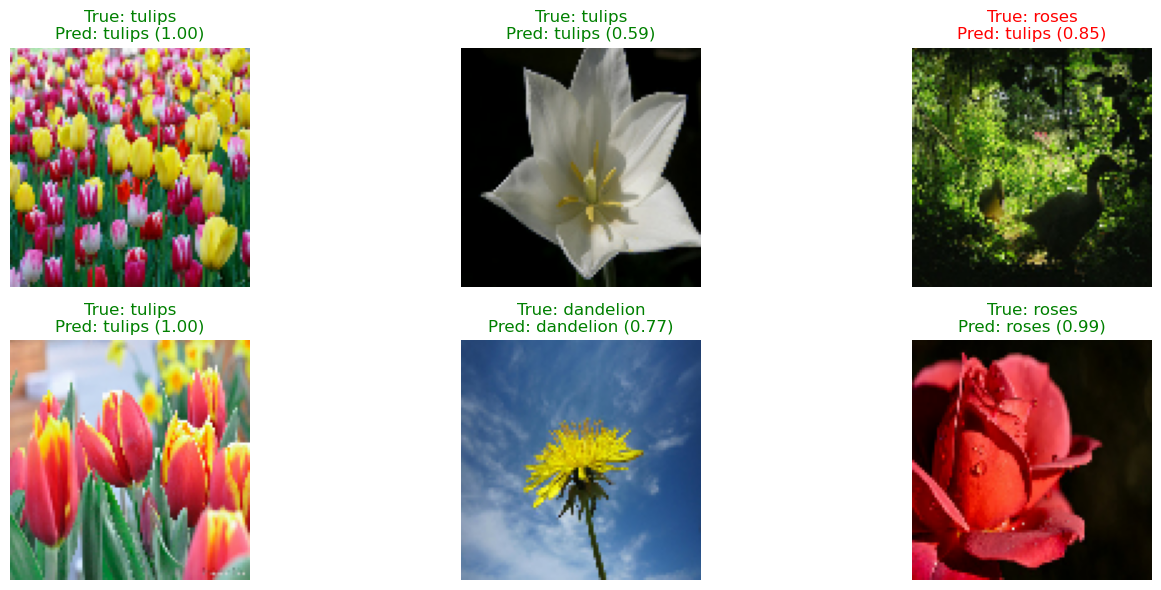

In [13]:
# Get predictions on one batch
for images, labels in val_ds.take(1):
    predictions = model_transfer.predict(images, verbose=0)
    predicted_classes = predictions.argmax(axis=-1)
    
    # Display some examples
    plt.figure(figsize=(15, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        true_class = class_names[labels[i]]
        pred_class = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]]
        
        # Color code: green if correct, red if wrong
        color = 'green' if true_class == pred_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence:.2f})', color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    break

## Combining Custom CNN with Pre-trained Features

A hybrid approach uses both custom convolutional layers and pre-trained features. This is useful when:

- Your dataset has unique characteristics not well represented in ImageNet
- You want to learn task-specific low-level features while leveraging pre-trained high-level features
- You have sufficient data to train custom layers without overfitting

### Building a Hybrid Model

We create two parallel branches:

1. **Custom CNN branch**: Learns task-specific features from scratch
2. **Pre-trained branch**: Extracts general features from ImageNet

Then concatenate and combine both feature sets for classification.

In [14]:
# Build hybrid model with two parallel branches
inputs = keras.Input(shape=image_size + (3,))
x = preprocess_input(inputs)  # Preprocess for MobileNetV2

# Branch 1: Custom CNN path - learns flower-specific features
custom_branch = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
custom_branch = layers.MaxPooling2D(2)(custom_branch)
custom_branch = layers.Conv2D(64, 3, activation='relu', padding='same')(custom_branch)
custom_branch = layers.GlobalAveragePooling2D()(custom_branch)  # Reduces to 64 features

# Branch 2: Pre-trained features - extracts general visual features
pretrained_branch = base_model(x, training=False)  # Keep frozen
pretrained_branch = layers.GlobalAveragePooling2D()(pretrained_branch)  # Reduces to 1280 features

# Combine both branches: concatenate custom (64) + pretrained (1280) = 1344 features
combined = layers.Concatenate()([custom_branch, pretrained_branch])
combined = layers.Dense(128, activation='relu')(combined)  # Learn feature combinations
combined = layers.Dropout(0.5)(combined)  # Regularization
outputs = layers.Dense(num_classes, activation='softmax')(combined)

model_hybrid = keras.Model(inputs, outputs, name='hybrid_model')

### Training the Hybrid Model

In [15]:
model_hybrid.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train hybrid model
history_hybrid = model_hybrid.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Evaluate
val_loss_hybrid, val_acc_hybrid = model_hybrid.evaluate(val_ds, verbose=0)
print(f'\nHybrid Model Results:')
print(f'  Validation Loss: {val_loss_hybrid:.4f}')
print(f'  Validation Accuracy: {val_acc_hybrid:.4f}')

Epoch 1/10
46/46 [==============================] - 8s 106ms/step - loss: 1.3431 - accuracy: 0.6335 - val_loss: 0.6358 - val_accuracy: 0.8256
Epoch 2/10
46/46 [==============================] - 3s 68ms/step - loss: 0.5051 - accuracy: 0.8515 - val_loss: 0.5789 - val_accuracy: 0.8406
Epoch 3/10
46/46 [==============================] - 3s 70ms/step - loss: 0.2536 - accuracy: 0.9179 - val_loss: 0.5472 - val_accuracy: 0.8392
Epoch 4/10
46/46 [==============================] - 3s 67ms/step - loss: 0.1374 - accuracy: 0.9574 - val_loss: 0.5644 - val_accuracy: 0.8433
Epoch 5/10
46/46 [==============================] - 3s 68ms/step - loss: 0.0693 - accuracy: 0.9837 - val_loss: 0.5564 - val_accuracy: 0.8433
Epoch 6/10
46/46 [==============================] - 3s 67ms/step - loss: 0.0378 - accuracy: 0.9949 - val_loss: 0.5879 - val_accuracy: 0.8460
Epoch 7/10
46/46 [==============================] - 3s 68ms/step - loss: 0.0233 - accuracy: 0.9983 - val_loss: 0.5981 - val_accuracy: 0.8474
Epoch 8/10
4

**Hybrid Model Characteristics:**

- Trains both custom and pre-trained pathways
- Custom layers can learn flower-specific patterns (petal textures, colors)
- Pre-trained features provide robust general visual understanding
- More trainable parameters than frozen transfer learning
- Useful when your domain has unique characteristics not in ImageNet

## Fine-tuning

Fine-tuning is the second transfer learning strategy. After training the new classification head with a frozen backbone, we:

1. **Unfreeze** some or all of the backbone layers
2. **Continue training** with a **much lower learning rate**
3. Allow the pre-trained weights to adapt slightly to our specific task

### Why Fine-tune?

- **Better adaptation**: Backbone features adjust to our specific dataset
- **Higher accuracy**: Often achieves better results than frozen features
- **Task-specific features**: Top layers learn patterns specific to flowers

### Risks and Precautions

- **Catastrophic forgetting**: High learning rate can destroy pre-trained knowledge
- **Overfitting**: More trainable parameters increase overfitting risk
- **Solution**: Use very small learning rate (10-100× smaller than initial training)

### Unfreezing the Backbone

We can unfreeze:
- **All layers**: Maximum flexibility
- **Top N layers**: Keeps early generic features frozen

Let's unfreeze the entire backbone:

In [16]:
# Unfreeze the base model - allows weights to update during training
base_model.trainable = True

print(f'Number of layers in base model: {len(base_model.layers)}')
print(f'Trainable layers: {sum([1 for layer in base_model.layers if layer.trainable])}')

Number of layers in base model: 154
Trainable layers: 154


### Recompiling with Lower Learning Rate

**Critical:** Use a much smaller learning rate for fine-tuning to avoid destroying pre-trained knowledge.

In [17]:
# Compile with very low learning rate (100× smaller than default)
# This prevents catastrophic forgetting of ImageNet features
model_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Default is 1e-3
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Model recompiled with learning rate: 1e-5")

Model recompiled with learning rate: 1e-5


### Fine-tuning Training

Continue training for a few more epochs.

In [18]:
epochs_finetune = 5
total_epochs = epochs_initial + epochs_finetune

# Continue training from where we left off
history_finetune = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1]
)

Epoch 10/15


2025-11-16 00:15:19.650459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


46/46 [==============================] - 11s 100ms/step - loss: 0.0963 - accuracy: 0.9792 - val_loss: 0.4295 - val_accuracy: 0.8583
Epoch 11/15
46/46 [==============================] - 3s 71ms/step - loss: 0.0380 - accuracy: 0.9983 - val_loss: 0.4286 - val_accuracy: 0.8638
Epoch 12/15
46/46 [==============================] - 3s 74ms/step - loss: 0.0217 - accuracy: 0.9993 - val_loss: 0.4289 - val_accuracy: 0.8610
Epoch 13/15
46/46 [==============================] - 3s 75ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.4363 - val_accuracy: 0.8638
Epoch 14/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.4400 - val_accuracy: 0.8692
Epoch 15/15
46/46 [==============================] - 3s 74ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.4441 - val_accuracy: 0.8692


### Visualizing Fine-tuning Results

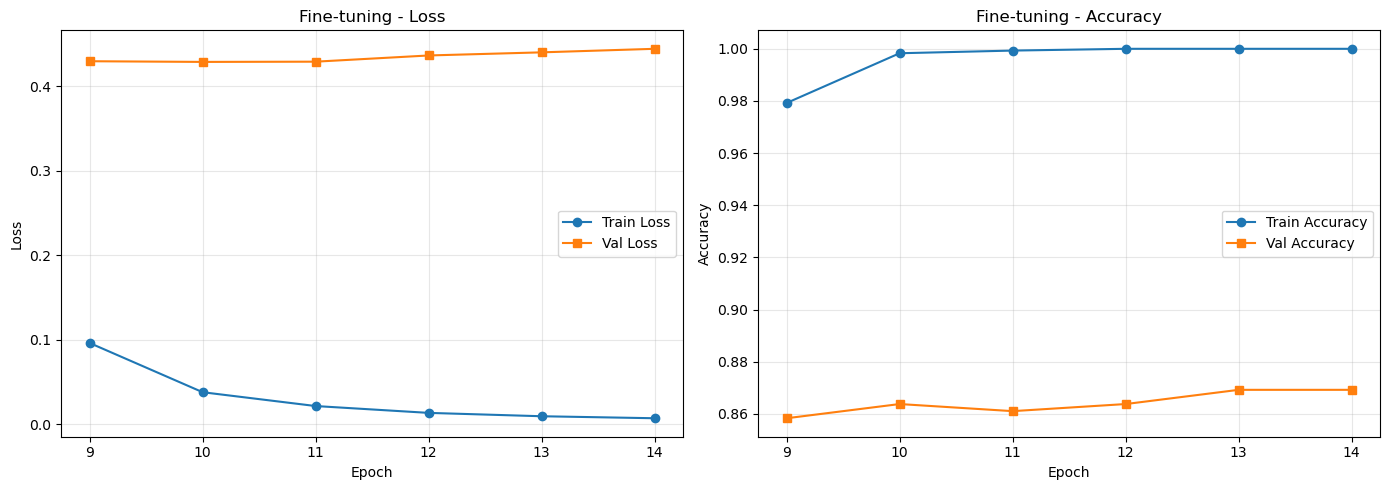


Fine-tuning Results:
  Validation Loss: 0.4441
  Validation Accuracy: 0.8692


In [19]:
plot_training_history(history_finetune, 'Fine-tuning')

val_loss_finetune, val_acc_finetune = model_transfer.evaluate(val_ds, verbose=0)
print(f'\nFine-tuning Results:')
print(f'  Validation Loss: {val_loss_finetune:.4f}')
print(f'  Validation Accuracy: {val_acc_finetune:.4f}')

### Combined Training Curve

Let's visualize the complete training process: frozen backbone + fine-tuning.

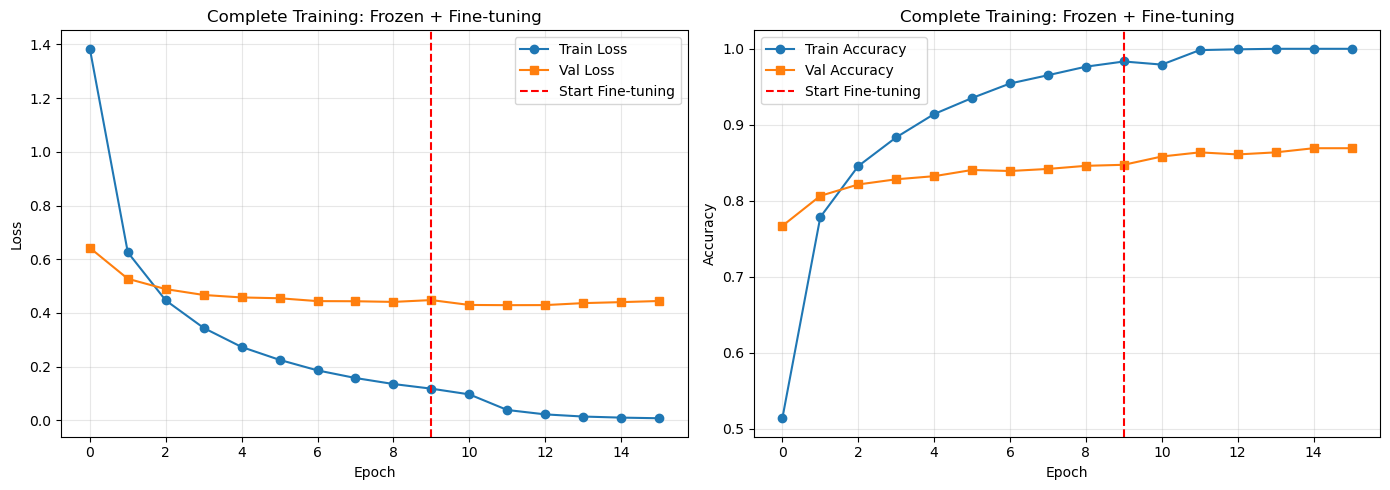

In [20]:
# Combine histories from both training phases
acc = history_transfer.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_transfer.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_transfer.history['loss'] + history_finetune.history['loss']
val_loss = history_transfer.history['val_loss'] + history_finetune.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(loss, label='Train Loss', marker='o')
ax1.plot(val_loss, label='Val Loss', marker='s')
ax1.axvline(x=epochs_initial-1, color='r', linestyle='--', label='Start Fine-tuning')  # Mark transition
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Complete Training: Frozen + Fine-tuning')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(acc, label='Train Accuracy', marker='o')
ax2.plot(val_acc, label='Val Accuracy', marker='s')
ax2.axvline(x=epochs_initial-1, color='r', linestyle='--', label='Start Fine-tuning')  # Mark transition
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Complete Training: Frozen + Fine-tuning')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparing Approaches

Let's summarize the different approaches we could use:

### Training from Scratch (Previous Notebook)

- Train all weights randomly initialized
- Requires more data and epochs
- Higher computational cost

### Transfer Learning (Frozen)

- Freeze pre-trained backbone
- Train only new classification layers
- Fast training, good baseline results

### Hybrid Model

- Combines custom CNN with pre-trained features
- Learns task-specific features while leveraging ImageNet knowledge
- More parameters than frozen, less than full fine-tuning

### Fine-tuning

- Start with frozen backbone training
- Then unfreeze and train with low learning rate
- Best accuracy, moderate training time

### Comparison Table

| Approach                  | Trainable Params | Training Time | Typical Accuracy | When to Use                          |
|---------------------------|------------------|---------------|------------------|--------------------------------------|
| From scratch (Notebook 05)| All (~500K-2M)   | Slow          | Baseline         | Large dataset, unique domain         |
| Frozen backbone           | Few (~10K-50K)   | Fast          | Good             | Limited data, similar to ImageNet    |
| Hybrid model              | Medium (~50K-200K)| Medium        | Good-Better      | Dataset with unique characteristics  |
| Fine-tuning               | All (~500K-3M)   | Medium        | Best             | Want highest accuracy, have some data|

### Performance Summary

In [21]:
print("Performance Comparison:")
print("="*60)
print(f"Transfer Learning (Frozen):  {val_acc_transfer:.4f}")
print(f"Hybrid Model:                {val_acc_hybrid:.4f}")
print(f"Fine-tuning:                 {val_acc_finetune:.4f}")
print("="*60)
print(f"\nImprovement from fine-tuning: {(val_acc_finetune - val_acc_transfer):.4f}")

Performance Comparison:
Transfer Learning (Frozen):  0.8474
Hybrid Model:                0.8460
Fine-tuning:                 0.8692

Improvement from fine-tuning: 0.0218


**Typical observations:**

- Transfer learning achieves good results quickly (70-80% accuracy in 10 epochs)
- Hybrid models can match or exceed frozen transfer learning
- Fine-tuning usually improves accuracy by 2-5%
- All approaches vastly outperform training from scratch with limited data

## Recap

**Transfer Learning Concept:**
- Reuse knowledge from models trained on large datasets (ImageNet with 1.4M images)
- Reduces data requirements and training time significantly
- Often achieves better results than training from scratch, especially with limited data

**Pre-trained Models:**
- Keras Applications provides many CNN architectures (MobileNetV2, EfficientNet, ResNet)
- Models pre-trained on ImageNet (1000 classes: animals, plants, objects)
- Different models offer tradeoffs: MobileNetV2 (fast), ResNet50 (accurate), EfficientNet (balanced)

**Model-Specific Preprocessing:**
- Each pre-trained model expects specific input format
- Always use model's preprocessing function (e.g., `mobilenet_v2.preprocess_input`)
- MobileNetV2 scales to [-1, 1], ResNet subtracts mean, EfficientNet normalizes

**Feature Extraction:**
- Freeze pre-trained backbone (`trainable=False`)
- Train only new classification layers
- Fast training, provides good baseline performance

**Hybrid Approach:**
- Combine custom CNN branch with pre-trained features
- Learn task-specific patterns while leveraging ImageNet knowledge
- Useful when dataset has unique characteristics

**Fine-tuning:**
- Unfreeze backbone after initial training with frozen weights
- Continue training with very low learning rate (e.g., 1e-5 vs default 1e-3)
- Allows weights to adapt to specific task without forgetting ImageNet features
- Usually improves accuracy by 2-5% over frozen features

**Best Practices:**
- Always start with frozen backbone training
- Use correct preprocessing for chosen backbone
- Use very low learning rate for fine-tuning (100× smaller)
- Monitor validation metrics to avoid overfitting